In [1]:
%pip uninstall text2emotion emoji -y
%pip install pandas numpy nltk textblob textstat text2emotion matplotlib seaborn wordcloud scipy scikit-learn nrclex text2emotion==0.0.5 emoji==1.6.3
%pip install transformers torch

import pandas as pd
import numpy as np
import re
# Text Processing
import nltk
from textblob import TextBlob
import textstat
import text2emotion as te
from nrclex import NRCLex

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Statistical Testing
from scipy.stats import ttest_ind, mannwhitneyu

# Modeling (Optional)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# NLTK downloads
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from transformers import pipeline

from collections import Counter
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170282 sha256=1af0ca5fd3883561190288df0a4434a61ada726b9007392046270d1d378dbd17
  Stored in directory: /root/.cache/pip/wheels/85/e1/6e/02053f229e270406b51792d6d511a55338c818642599fa9cfe
  Created wheel for nrclex: filename=NRC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# Load data
fund_df = pd.read_csv('cleaned_fundme_data.csv')

print(fund_df.head())
#print(fund_df.columns)
#fund_df.info()


   amount_to_goal  balance      bene_name                    cat_name  \
0         66484.0   803516        Unknown              Animals & Pets   
1          4150.0    69589  Eric Lagstein  Medical, Illness & Healing   
2          8066.0    26934        Unknown        Funerals & Memorials   
3         34112.0    15888        Unknown              Animals & Pets   
4          4150.0    34322        Unknown        Funerals & Memorials   

   category_id    charity_name            city  comment_count_full country  \
0            3  happyy cat Inc  Port Jefferson                  38      US   
1           11     Independent         Wyckoff                   1      US   
2            9     Independent    Passaic Park                   1      US   
3            3     Independent         Newtown                   0      US   
4            9     Independent      Maplecrest                   7      US   

                  created_at  ... status              timeout_start  \
0  2025-03-31 19:28:1

In [4]:
fund_df['pct_goal_achieved'] = (fund_df['balance'] / fund_df['goalamount']) * 100
fund_df[['balance', 'goalamount', 'pct_goal_achieved']].tail()
fund_df['success_flag'] = (fund_df['pct_goal_achieved'] >= 80).astype(int)
fund_df['success_flag'].value_counts(normalize=True)

,proportion
success_flag,
0,0.77907
1,0.22093


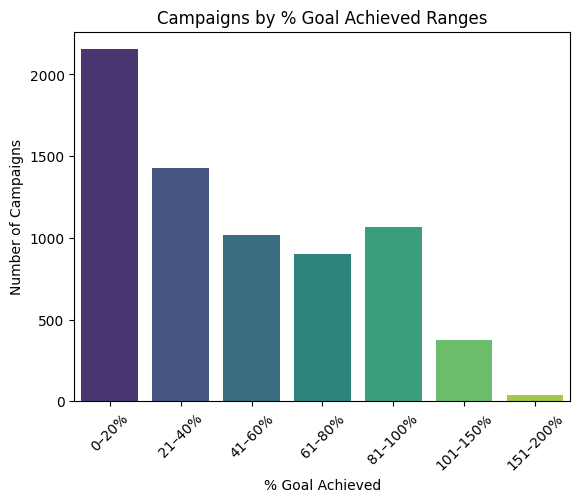

In [5]:
bins = [0, 20, 40, 60, 80, 100, 150, 200]
labels = ['0–20%', '21–40%', '41–60%', '61–80%', '81–100%', '101–150%', '151–200%']
fund_df['goal_achieved_range'] = pd.cut(fund_df['pct_goal_achieved'], bins=bins, labels=labels)

sns.countplot(data=fund_df, x='goal_achieved_range', order=labels, palette='viridis')
plt.title('Campaigns by % Goal Achieved Ranges')
plt.xlabel('% Goal Achieved')
plt.ylabel('Number of Campaigns')
plt.xticks(rotation=45)
plt.show()


In [6]:
# Word count
fund_df['text_word_count'] = fund_df['funddescription'].apply(lambda x: len(str(x).split()))

# Character count (excluding spaces)
fund_df['text_char_count'] = fund_df['funddescription'].apply(lambda x: len(str(x).replace(" ", "")))

# Average word length
fund_df['text_avg_word_len'] = fund_df['text_char_count'] / fund_df['text_word_count']

# Readability score (Flesch Reading Ease)
fund_df['readability'] = fund_df['funddescription'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
#fund_df['gunning_fog'] = df['funddescription'].apply(textstat.gunning_fog)

# Sentiment polarity (-1 to 1) and subjectivity (0 to 1)
fund_df['sentiment_polarity'] = fund_df['funddescription'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
fund_df['sentiment_subjectivity'] = fund_df['funddescription'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)


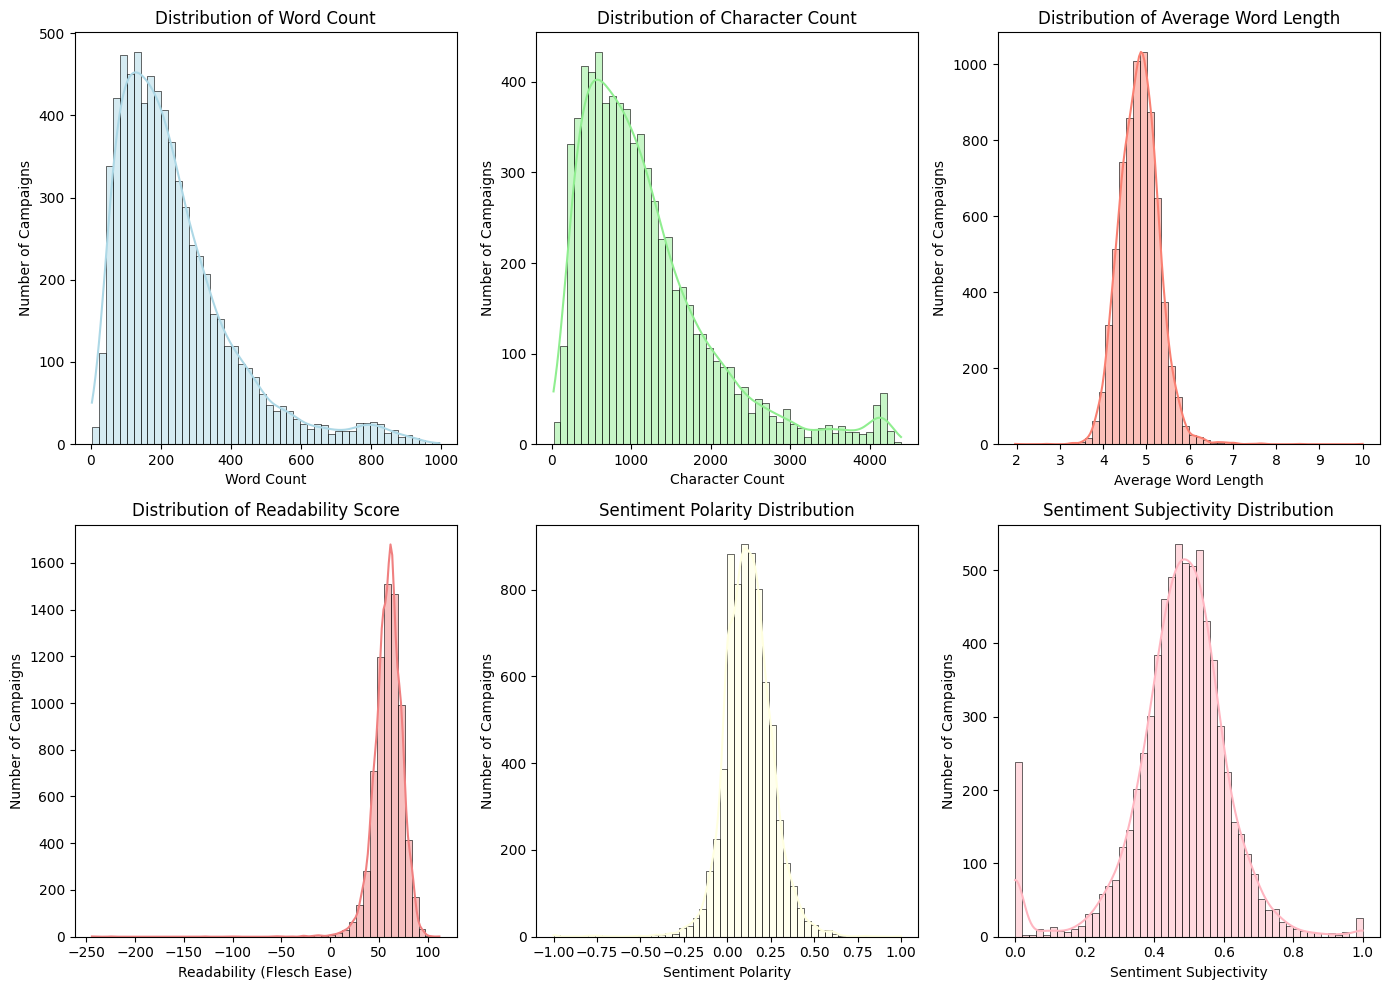

In [7]:
# Set up the figure
plt.figure(figsize=(14, 10))

# 1. Word Count Distribution
plt.subplot(2, 3, 1)
sns.histplot(fund_df['text_word_count'], bins=50, kde=True, color='lightblue')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Campaigns')

# 2. Character Count Distribution
plt.subplot(2, 3, 2)
sns.histplot(fund_df['text_char_count'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Character Count')
plt.xlabel('Character Count')
plt.ylabel('Number of Campaigns')

# 3. Average Word Length Distribution
plt.subplot(2, 3, 3)
sns.histplot(fund_df['text_avg_word_len'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Average Word Length')
plt.xlabel('Average Word Length')
plt.ylabel('Number of Campaigns')

# 4. Readability Score Distribution
plt.subplot(2, 3, 4)
sns.histplot(fund_df['readability'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Readability Score')
plt.xlabel('Readability (Flesch Ease)')
plt.ylabel('Number of Campaigns')

# 5. Sentiment Polarity Distribution
plt.subplot(2, 3, 5)
sns.histplot(fund_df['sentiment_polarity'], bins=50, kde=True, color='lightyellow')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Campaigns')

# 6. Sentiment Subjectivity Distribution
plt.subplot(2, 3, 6)
sns.histplot(fund_df['sentiment_subjectivity'], bins=50, kde=True, color='lightpink')
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Number of Campaigns')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
"""from transformers import pipeline, AutoTokenizer
import pandas as pd

# Load pre-trained emotion detection pipeline and tokenizer
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

def extract_emotions_huggingface(df, text_column):
    def get_emotions(text):
        if isinstance(text, str) and text.strip():
            # Truncate to model's max token length (512)
            tokens = tokenizer.tokenize(text)
            truncated_tokens = tokens[:512]
            truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
            try:
                return emotion_pipeline(truncated_text)[0]  # Most likely emotion
            except Exception as e:
                return {"label": "ERROR", "score": 0.0}
        else:
            return {}

    # Apply emotion extraction
    emotion_df = df[text_column].apply(get_emotions).apply(pd.Series).fillna(0)

    # Return combined dataframe
    return pd.concat([df.reset_index(drop=True), emotion_df], axis=1)


fund_df = extract_emotions_huggingface(fund_df, 'funddescription')"""


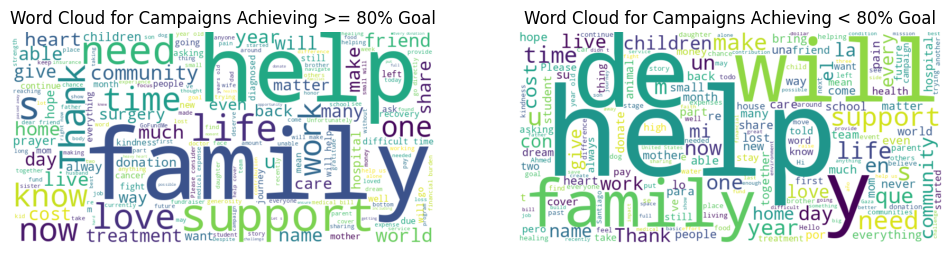

In [10]:
# --- Word Clouds: Based on Goal Achieved Percentage (e.g., above and below a threshold) ---
successful_text = ' '.join(fund_df[fund_df['pct_goal_achieved'] >= 0.8]['funddescription'].astype(str))
failed_text = ' '.join(fund_df[fund_df['pct_goal_achieved'] < 0.8]['funddescription'].astype(str)) \

wordcloud_successful = WordCloud(width=800, height=400, background_color='white').generate(successful_text)
wordcloud_failed = WordCloud(width=800, height=400, background_color='white').generate(failed_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_successful, interpolation='bilinear')
plt.title('Word Cloud for Campaigns Achieving >= 80% Goal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_failed, interpolation='bilinear')
plt.title('Word Cloud for Campaigns Achieving < 80% Goal')
plt.axis('off')
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Limit vocabulary size and ignore very common/rare words
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,       # top 100 words by TF-IDF score
    stop_words='english',   # remove common English words
    min_df=5                # ignore terms that appear in <5 docs
)

# Fit and transform funddescription
tfidf_matrix = tfidf_vectorizer.fit_transform(fund_df['funddescription'].astype(str))

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{word}" for word in tfidf_vectorizer.get_feature_names_out()])

# Merge TF-IDF features back into main DataFrame
fund_df = pd.concat([fund_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

print("TF-IDF features added to fund_df.")


TF-IDF features added to fund_df.


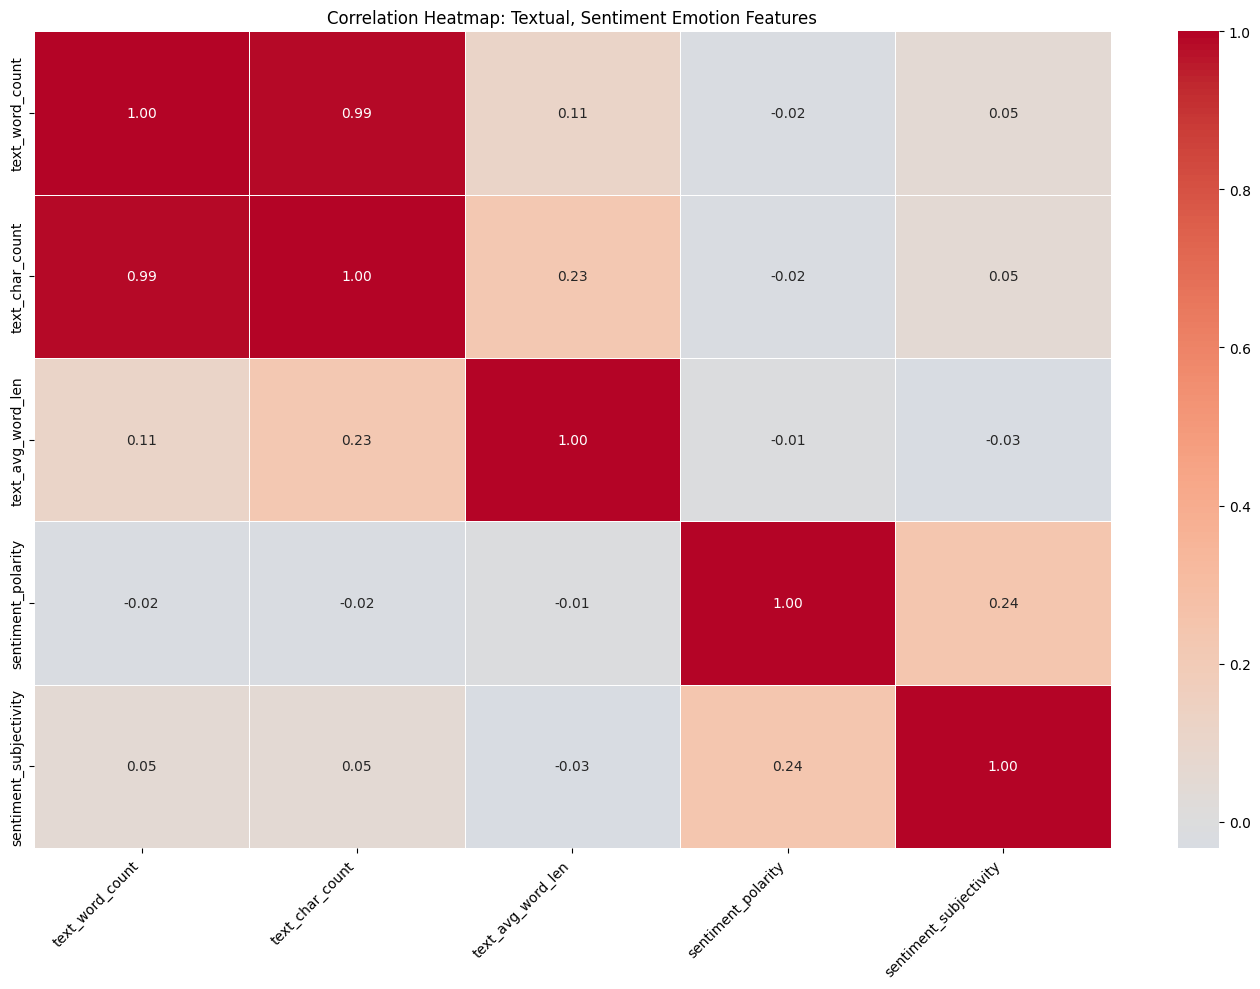

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all relevant features
textual_features = ['text_word_count', 'text_char_count', 'text_avg_word_len']
sentiment_features = ['sentiment_polarity', 'sentiment_subjectivity']

# Combine all into a subset
features_to_analyze = textual_features + sentiment_features
corr_df = fund_df[features_to_analyze].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Textual, Sentiment Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pd.concat([fund_df[[*features_to_analyze]], tfidf_df], axis=1)
# Scale textual features
scaler = StandardScaler()
X[features_to_analyze] = scaler.fit_transform(X[features_to_analyze])
y = fund_df['success_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier()
}


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probs)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc, 4)
    })
    trained_models[name] = model

results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

print("=== Model Evaluation Results ===")
print(results_df)


=== Model Evaluation Results ===
                    Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
2           Random Forest    0.7789     0.4444  0.0129    0.0250   0.5932
3             Extra Trees    0.7775     0.2000  0.0032    0.0063   0.5912
4       Gradient Boosting    0.7760     0.3529  0.0193    0.0366   0.5895
0     Logistic Regression    0.7803     0.5455  0.0193    0.0373   0.5857
7                AdaBoost    0.7782     0.0000  0.0000    0.0000   0.5828
6  Support Vector Machine    0.7796     0.0000  0.0000    0.0000   0.5395
5     K-Nearest Neighbors    0.7250     0.2308  0.1061    0.1454   0.5322
1           Decision Tree    0.6634     0.2389  0.2412    0.2400   0.5132


## Feature Importance

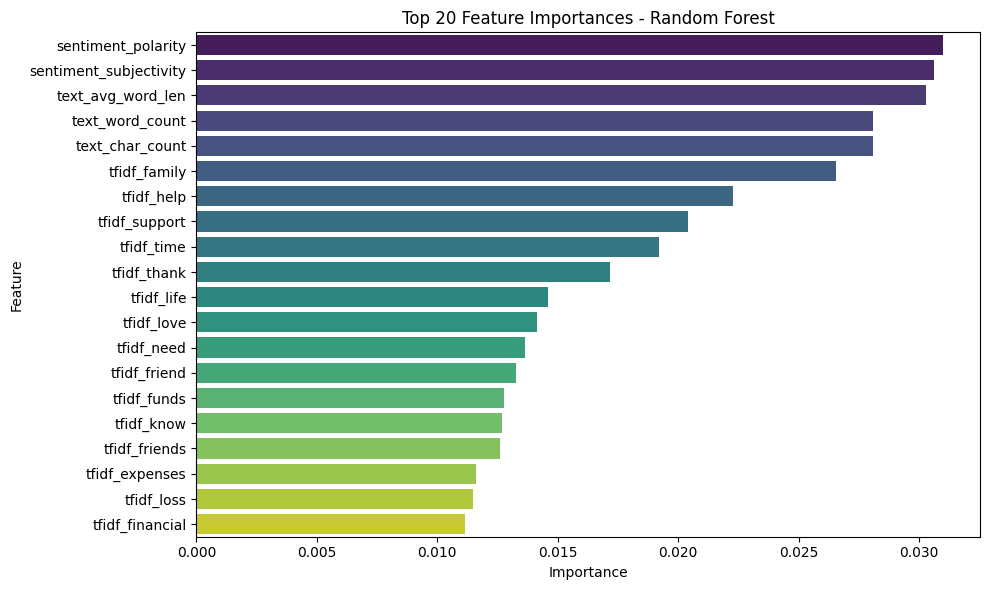

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick the best performing tree-based model
best_tree_model_name = results_df[results_df['Model'].isin(['Random Forest', 'Extra Trees', 'Gradient Boosting'])].iloc[0]['Model']
best_tree_model = trained_models[best_tree_model_name]

# Extract feature importances
importances = best_tree_model.feature_importances_
feature_names = X.columns

# Plot top 20 features
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top 20 Feature Importances - {best_tree_model_name}')
plt.tight_layout()
plt.show()


## Confusion Matric and ROC

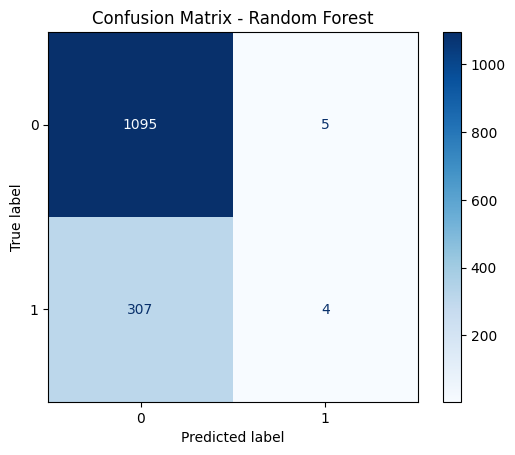

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot for best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()




In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

# Plot ROC curve for each model
for model_name in results_df['Model']:
    model = trained_models[model_name]
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    fig.add_trace(
        go.Scatter(
            x=fpr,
            y=tpr,
            mode='lines',
            name=f'{model_name} (AUC={roc_auc:.3f})'
        )
    )

# Adding a  baseline
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(dash='dash'),
        name='Random Chance'
    )
)

# Update layout
fig.update_layout(
    title='ROC Curves Comparison - All Models (Plotly)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=1000,
    height=600,
    legend=dict(
        x=0.75,
        y=0.25,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(0,0,0,0)'
    ),
    template='plotly_white'
)

fig.show()